In [1]:
# df
import pandas as pd

# formulas
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# plots
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline

Данные взяты из бесплатного курса "Основы статистики" на платформе Stepik. В них представлена информация по сравнению уровня гена при различных видах терапии. Выборки независимые


**Цель** - оценить влияние вида терапии на уровень гена

Близости средних будет  оцениваться с помощью *однофакторного дисперсионного анализа* и критерия *Краскела-Уоллиса*

# 1. Загрузка и предобработка данных


In [2]:
# Data loading
url = 'https://stepik.org/media/attachments/lesson/8083/genetherapy.csv'
gene_therapy = pd.read_csv(url)
gene_therapy.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [3]:
# alpha
alpha = 0.05

In [4]:
# Check NA
gene_therapy.isna().sum()

expr       0
Therapy    0
dtype: int64

In [5]:
# Split by type of therapy
therapy_pivot = gene_therapy.pivot(values='expr', columns='Therapy')
therapies =pd.DataFrame()
for type_th in therapy_pivot:
    therapies[type_th] = therapy_pivot[type_th].dropna().reset_index(drop=True)
therapies

,A,B,C,D
0,100.0,100.0,91.0,92.0
1,96.0,100.0,96.0,85.0
2,101.0,95.0,94.0,95.0
3,95.0,84.0,96.0,89.0
4,103.0,101.0,91.0,91.0
5,99.0,101.0,85.0,91.0
6,97.0,95.0,98.0,99.0
7,96.0,106.0,93.0,94.0
8,98.0,105.0,100.0,97.0
9,106.0,97.0,85.0,94.0


In [6]:
# Basic metrics
therapies.describe().round(1)

,A,B,C,D
count,15.0,15.0,15.0,15.0
mean,99.7,98.8,94.4,92.3
std,4.2,5.9,5.2,3.7
min,95.0,84.0,85.0,85.0
25%,96.0,95.0,91.0,90.5
50%,99.0,100.0,96.0,92.0
75%,103.5,102.0,98.0,94.5
max,106.0,107.0,101.0,99.0


In [7]:
# Chart settings
sns.set(style='whitegrid',
        font_scale=1.2,
        rc = {'figure.figsize': (14,6)})

# 2. Проверка требований для использования one-way ANOVA

* Выборки равны по колличеству данных
* Выборки независимые
* Данные дискретны 

#### Проверка нормальности распределения данных 

Text(0.5, 1.0, 'Distribution by therapy\n')

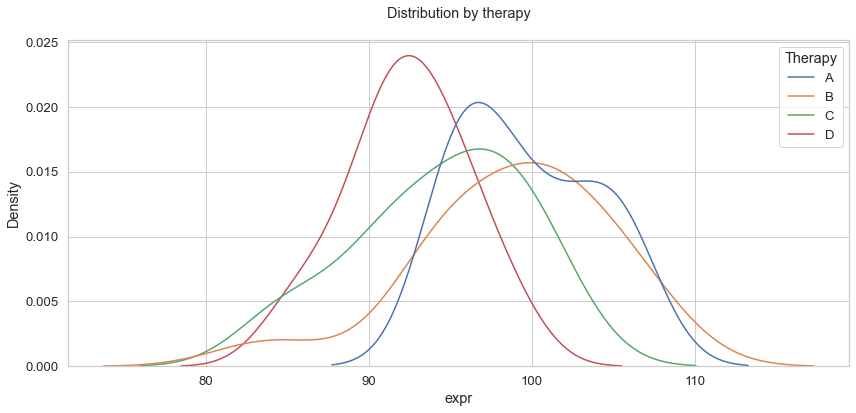

In [8]:
# Data distribution

ax=sns.kdeplot(data=gene_therapy, x='expr', hue='Therapy')
ax.set_title('Distribution by therapy\n')

In [9]:
# Function for plotting histogram and QQ-plot
def sample_plot(type_th):
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    
    fig.subplots_adjust(hspace=0.4, wspace=0.25)
    fig.suptitle(f'Distribution therapy {type_th}\n')

    sns.histplot(data=therapies[type_th], 
                    ax=ax1, 
                    kde=True)
    ax1.set(xlabel='expr', ylabel='Density')

    sm.qqplot(therapies[type_th], line='s', ax=ax2)


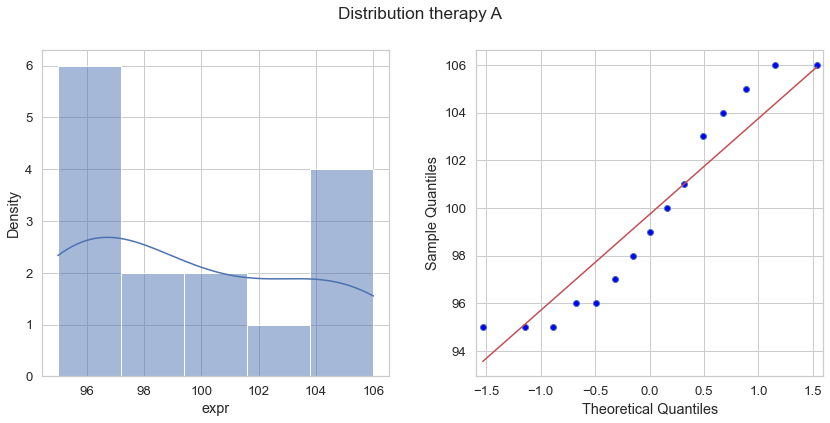

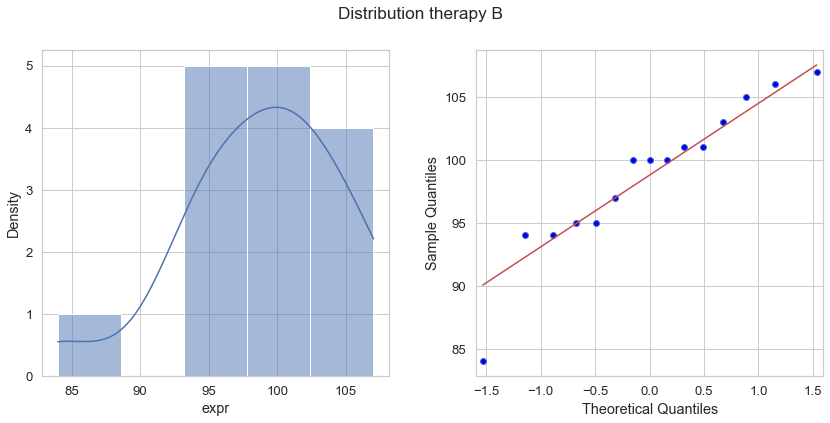

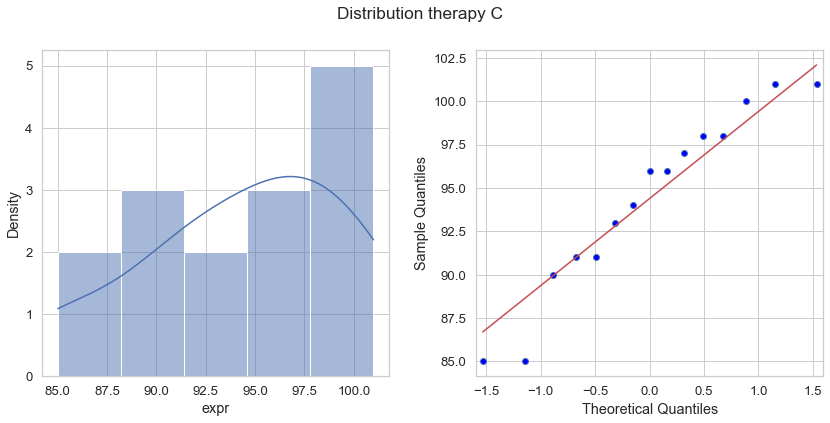

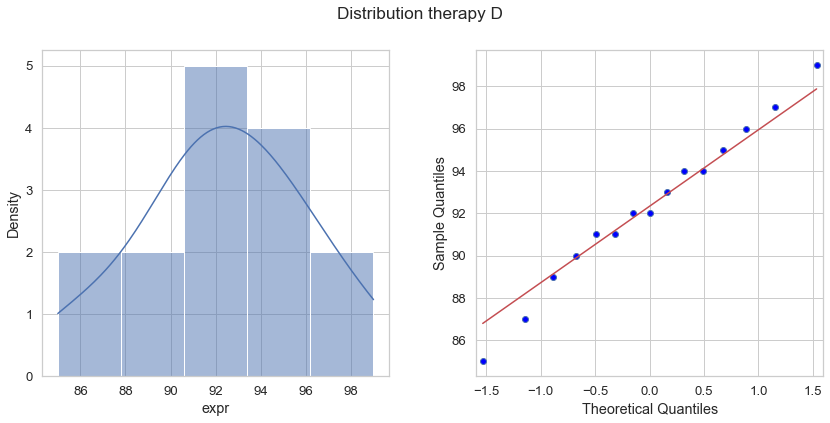

In [10]:
# Hide warnings
import warnings
warnings.simplefilter('ignore')

for type_th in therapies:
    sample_plot(type_th)

Т.к. размеры выборок небольшие, то графики не дают точного понимания нормальности распределения.
Проведем проверку по критерию Шапиро-Уилка

H0: выборка распределена нормальным образом

α = 0.05

In [11]:
# Shapiro–Wilk test
for type_th in therapies:
    pvalue = stats.shapiro(therapies[type_th]).pvalue
    pvalue = round(pvalue, 4)
    print(f'По критерию Шапиро-Уилка для терапии типа {type_th} {pvalue=}. Значение меньше 0.05: {pvalue<alpha}')

По критерию Шапиро-Уилка для терапии типа A pvalue=0.062. Значение меньше 0.05: False
По критерию Шапиро-Уилка для терапии типа B pvalue=0.2374. Значение меньше 0.05: False
По критерию Шапиро-Уилка для терапии типа C pvalue=0.2616. Значение меньше 0.05: False
По критерию Шапиро-Уилка для терапии типа D pvalue=0.9998. Значение меньше 0.05: False


При уровне значимость = 0.05, ни для одной выборки не имеет смысла отвергать нулевую гипотезу. Можно считать, что выборки равпределены нормальным образом.

#### Проверка гомогенности дисперсий по критерию Левена
H0: дисперсии выборок гомогенны

α = 0.05

In [12]:
# Levene’s test
res = stats.levene(therapies['A'], therapies['B'], therapies['C'], therapies['D'])
print(res)

pvalue = round(res.pvalue, 4)
print(f'По критерию Левена {pvalue=}. Значение меньше 0.05: {pvalue<alpha}')


LeveneResult(statistic=0.6477908627745761, pvalue=0.5876330665111003)
По критерию Левена pvalue=0.5876. Значение меньше 0.05: False


При уровне значимость = 0.05, не имеет смысла отвергать нулевую гипотезу. Можно считать дисперсии гомогенными. 

# 3. one-way ANOVA

Т.к. все условия для дисперсионного анализа соблюдаются, оценку анализа можно считать статистически достоверной

H0: средние значения выборок равны

α = 0.05

In [13]:
# One-way ANOVA
res = stats.f_oneway(therapies['A'], therapies['B'], therapies['C'], therapies['D'])
print(res)

pvalue = round(res.pvalue, 4)
print(f'По ANOVA {pvalue=}. Значение меньше 0.05: {pvalue<alpha}')

F_onewayResult(statistic=8.03730248114399, pvalue=0.00015249722895229536)
По ANOVA pvalue=0.0002. Значение меньше 0.05: True


Т.к. значение pvalue меньше, то имеет смысл отклонить нулевую гипотезу. Значит как минимум два средних отличаются

Оценим какие группы отличаются. Для начала построим boxplot

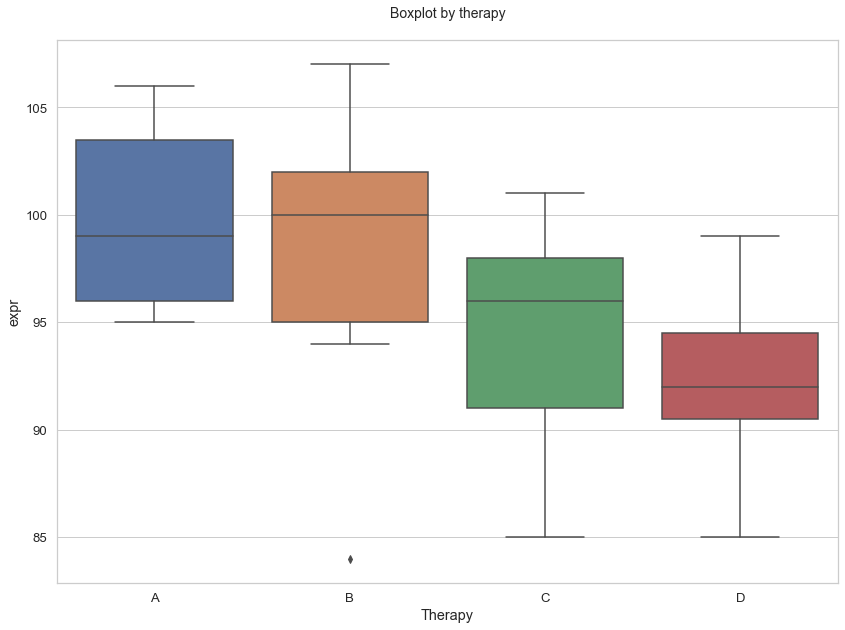

In [38]:
# Boxplot
bx = sns.boxplot(data=gene_therapy, x="Therapy", y="expr")
bx.set_title('Boxplot by therapy\n', fontsize=14)
bx.figure.set_size_inches(14,10)

# Boxplot by plotly but not visible in github
#px.box(data_frame=gene_therapy, x="Therapy", y="expr", title="Box plot of expr", points='outliers')

Определим различия выборок по критерию Тьюки

H0: средние выборок равны

α = 0.05

In [15]:
gene_therapy.head(3)

,expr,Therapy
0,100,A
1,96,A
2,101,A


In [16]:
tukey = pairwise_tukeyhsd(endog=gene_therapy['expr'],
                          groups=gene_therapy['Therapy'],
                          alpha=alpha)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -0.9333    0.9  -5.5961  3.7294  False
     A      C  -5.3333 0.0189  -9.9961 -0.6706   True
     A      D     -7.4  0.001 -12.0628 -2.7372   True
     B      C     -4.4 0.0712  -9.0628  0.2628  False
     B      D  -6.4667 0.0029 -11.1294 -1.8039   True
     C      D  -2.0667 0.6296  -6.7294  2.5961  False
-----------------------------------------------------


Отклоняем нулевую гипотезу для пар: A-C, A-D, B-D

# 4. Оценим данные по критерию Краскела-Уоллиса

H0: средние значения выборок равны

α = 0.05

In [17]:
res = stats.kruskal(therapies['A'], therapies['B'], therapies['C'], therapies['D'])
print(res)

pvalue = round(res.pvalue, 4)
print(f'По Краскелу-Уоллису {pvalue=}. Значение меньше 0.05: {pvalue<alpha}')

KruskalResult(statistic=19.32631265637935, pvalue=0.00023404560065198445)
По Краскелу-Уоллису pvalue=0.0002. Значение меньше 0.05: True


Т.к. значение pvalue меньше, то имеет смысл отклонить нулевую гипотезу. Значит как минимум два средних отличаются

# 5. Вывод

Оба критерия показали разницу в выборка, значит использование разных видов терапии приводит к различным значениям гена. Причем пары A-C, A-D, B-D дают статистически различные результаты